<a href="https://colab.research.google.com/github/jm5159/E4511-2021-Mao/blob/master/modeling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install AMPL packages

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:

! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

# ! wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh 
# ! chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
# ! time bash Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!pip install mordred
!pip install --upgrade bravado
!pip install molvs

!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-04-28 00:01:51--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   145MB/s    in 3.8s    

2021-04-28 00:01:55 (133 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37_0
    - anacond

In [3]:
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_final.csv

--2021-04-28 00:08:41--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3199248 (3.1M) [text/plain]
Saving to: ‘CYP3A4_cur_final.csv’

CYP3A4_cur_final.cs 100%[===================>]   3.05M  --.-KB/s    in 0.09s   

2021-04-28 00:08:41 (34.4 MB/s) - ‘CYP3A4_cur_final.csv’ saved [3199248/3199248]



In [4]:
!pip install hyperopt

     |████████████████████████████████| 972kB 8.3MB/s 


### Load packages and dataset

In [5]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import parameter_parser as parse
import atomsci.ddm.pipeline.model_pipeline as mp
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
h1 = pd.read_csv("CYP3A4_cur_final.csv")

In [10]:
h1

,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,Compound_ID,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL1537880,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,NaN,5.300000,0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,WNUWUYIZADTROQ-UHFFFAOYSA-N,5.300000,NaN,0,0
1,CHEMBL1515033,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,NaN,5.100000,0,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,LFQJIVPPRFXMAC-AWEZNQCLSA-N,5.100000,NaN,0,0
2,CHEMBL3422242,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,<,4.522879,0,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,HVEVDFRWOQHAPJ-CKMNQQOVSA-N,4.522879,NaN,0,0
3,CHEMBL1526043,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,NaN,4.400000,0,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,QIZLBSOCEJVBTG-UHFFFAOYSA-N,4.400000,NaN,0,0
4,CHEMBL3145019,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,NaN,4.800000,0,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,IYIGLQSFYOLXCS-UHFFFAOYSA-N,4.800000,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
18637,CHEMBL3932169,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NaN,5.515700,0,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,NCZXBZJVJRJUSC-GOSISDBHSA-N,5.515700,NaN,0,0
18638,CHEMBL4210866,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,NaN,4.481486,0,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,BSNVRJYSKXDALK-VQIMIIECSA-N,4.481486,NaN,0,0
18639,CHEMBL1465534,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,NaN,5.050000,0,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,ILMKPNZNEYHDGO-UHFFFAOYSA-N,5.050000,NaN,0,0
18640,CHEMBL3237445,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,<,5.000000,0,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,FLNHSHVOGZEONH-UHFFFAOYSA-N,5.000000,NaN,0,0


In [11]:
h1.shape

(18642, 11)

### Split the dataset

In [12]:
train_file = "CYP3A4_cur_final.csv"
response_col = "active"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 00:11:38,457 Splitting data by scaffold
2021-04-28 00:11:51,832 Dataset split table saved to /CYP3A4_cur_final_train_valid_test_scaffold_3f198ff7-ad81-495c-9c41-683b3052d737.csv


### Train an initial model

In [13]:
listing = glob.glob(os.path.join("/", "CYP3A4_cur_final_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "active"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [14]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 00:13:24,815 Previous dataset split restored
2021-04-28 00:13:45,551 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/574ec3bf-4cda-4f43-bd41-f378f4f9093a/model_metadata.json
2021-04-28 00:13:45,806 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/574ec3bf-4cda-4f43-bd41-f378f4f9093a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_574ec3bf-4cda-4f43-bd41-f378f4f9093a.tar.gz


In [15]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"AUC score of validation set: {pred_results['roc_auc_score']:.3f}")


AUC score of validation set: 0.840


In [17]:
listing = glob.glob(os.path.join("/", "CYP3A4_cur_final_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "active"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"
    }

In [18]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 00:21:59,177 Previous dataset split restored
2021-04-28 00:22:19,978 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/817316e3-da59-4716-87a8-eebf428ab498/model_metadata.json
2021-04-28 00:22:20,235 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/817316e3-da59-4716-87a8-eebf428ab498/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_817316e3-da59-4716-87a8-eebf428ab498.tar.gz


In [19]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"AUC score of validation set: {pred_results['roc_auc_score']:.3f}")

AUC score of validation set: 0.824


In [ ]:
pred_df = pl.predict_on_dataframe(h1)
pred_df = pred_df.merge(h1[["rdkit_smiles", "active"]], on="rdkit_smiles")
pred_df = pred_df.assign(pred_error=pred_df.active-pred_df.pred)

2021-04-02 04:40:37,502 Featurizing data...
2021-04-02 04:41:47,575 Done


number of features: 1024


In [ ]:
pred_df

,rdkit_smiles,pred,active,pred_error
0,Cc1ccc(-c2nnc(C)c(N3CC(C)OC(C)C3)n2)cc1,0,0,0
1,CS(=O)(=O)N1CCC[C@@]2(CCN(c3ccncc3)C2)C1,0,0,0
2,Cc1cc([C@H]2C[C@H]3[C@@H](C)SC(N)=N[C@@]3(c3cc...,0,0,0
3,N#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)c1,0,0,0
4,Cc1nn(C(C)(C)C)c(O)c1Sc1ccc(Cl)cc1,0,0,0
...,...,...,...,...
18637,CC(C)[C@@H]1c2nn(-c3cccc(S(C)(=O)=O)c3)cc2CN1c...,0,0,0
18638,N[C@@H]1CCC=C(c2ccc(F)cc2)[C@H]1CNc1cc(F)c(S(=...,0,0,0
18639,O=[N+]([O-])c1cccc(-c2nnn(C34CC5CC(CC(C5)C3)C4...,0,0,0
18640,Cc1nccc2c3cnc(Nc4ccc(N5CCNCC5)cn4)nc3n(C3CCCC3...,0,0,0


### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

In [ ]:
estimators = [16,32,64,128]
depth=[16,32,64,128]
features=[16,32,64,128]

rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []
for rf_estimator in estimators:
    for rf_depth in depth:
        for rf_feature in features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_auc = pred_results['roc_auc_score']
            valid_auc_list.append(valid_auc)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-02 03:05:21,098 Previous dataset split restored
2021-04-02 03:05:26,737 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/55dee9d4-708c-4d77-824a-424b97bf1dd7/model_metadata.json
2021-04-02 03:05:26,748 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/55dee9d4-708c-4d77-824a-424b97bf1dd7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_55dee9d4-708c-4d77-824a-424b97bf1dd7.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.8230336762804294
number of features: 1024


2021-04-02 03:06:41,279 Previous dataset split restored
2021-04-02 03:06:47,079 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/84c61750-a585-4779-99fa-ac8819438b4d/model_metadata.json
2021-04-02 03:06:47,091 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/84c61750-a585-4779-99fa-ac8819438b4d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_84c61750-a585-4779-99fa-ac8819438b4d.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.7802271321751841
number of features: 1024


2021-04-02 03:08:01,608 Previous dataset split restored
2021-04-02 03:08:07,669 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5c22d317-bc56-48ae-b672-3f63b3773a16/model_metadata.json
2021-04-02 03:08:07,678 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5c22d317-bc56-48ae-b672-3f63b3773a16/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_5c22d317-bc56-48ae-b672-3f63b3773a16.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.7447124304267162
number of features: 1024


2021-04-02 03:09:22,389 Previous dataset split restored
2021-04-02 03:09:28,865 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/c6ec13a7-455a-4c0f-82a1-775efa9f5b3f/model_metadata.json
2021-04-02 03:09:28,874 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/c6ec13a7-455a-4c0f-82a1-775efa9f5b3f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_c6ec13a7-455a-4c0f-82a1-775efa9f5b3f.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.7731714173272615
number of features: 1024


2021-04-02 03:10:43,430 Previous dataset split restored
2021-04-02 03:10:49,223 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/95c3d6ce-22bf-41a7-9210-170ce6e14db7/model_metadata.json
2021-04-02 03:10:49,238 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/95c3d6ce-22bf-41a7-9210-170ce6e14db7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_95c3d6ce-22bf-41a7-9210-170ce6e14db7.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.772738516894361
number of features: 1024


2021-04-02 03:12:03,686 Previous dataset split restored
2021-04-02 03:12:09,554 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8116dfe6-5673-40d7-b599-313ac441d4e9/model_metadata.json
2021-04-02 03:12:09,566 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8116dfe6-5673-40d7-b599-313ac441d4e9/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8116dfe6-5673-40d7-b599-313ac441d4e9.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.7350368246472142
number of features: 1024


2021-04-02 03:13:24,394 Previous dataset split restored
2021-04-02 03:13:30,673 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8d101745-7319-41ed-910d-cd069d19eda5/model_metadata.json
2021-04-02 03:13:30,683 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8d101745-7319-41ed-910d-cd069d19eda5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8d101745-7319-41ed-910d-cd069d19eda5.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.7457300275482094
number of features: 1024


2021-04-02 03:14:45,508 Previous dataset split restored
2021-04-02 03:14:52,619 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/0eb50e20-7023-423f-8efc-62c285018c4e/model_metadata.json
2021-04-02 03:14:52,629 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/0eb50e20-7023-423f-8efc-62c285018c4e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_0eb50e20-7023-423f-8efc-62c285018c4e.tar.gz
rf_estimators: 16, rf_max_depth: 32, rf_max_features: 128, valid_auc: 0.7978298757519537
number of features: 1024


2021-04-02 03:16:07,429 Previous dataset split restored
2021-04-02 03:16:13,209 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/44fe776c-ce7f-47da-be0d-e8d6ee5fccc9/model_metadata.json
2021-04-02 03:16:13,225 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/44fe776c-ce7f-47da-be0d-e8d6ee5fccc9/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_44fe776c-ce7f-47da-be0d-e8d6ee5fccc9.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_auc: 0.8130095013211897
number of features: 1024


2021-04-02 03:17:27,573 Previous dataset split restored
2021-04-02 03:17:33,497 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d36bbfd3-abc4-4c90-88d3-2ab969f8abf7/model_metadata.json
2021-04-02 03:17:33,510 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d36bbfd3-abc4-4c90-88d3-2ab969f8abf7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d36bbfd3-abc4-4c90-88d3-2ab969f8abf7.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.7971833361443752
number of features: 1024


2021-04-02 03:18:48,057 Previous dataset split restored
2021-04-02 03:18:54,298 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d8b24221-be8f-4bb8-a4ae-cca58916d7fa/model_metadata.json
2021-04-02 03:18:54,309 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d8b24221-be8f-4bb8-a4ae-cca58916d7fa/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d8b24221-be8f-4bb8-a4ae-cca58916d7fa.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.7686568842412999
number of features: 1024


2021-04-02 03:20:08,745 Previous dataset split restored
2021-04-02 03:20:15,772 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a943dd37-bed0-4259-a9fa-b176cbd67f1c/model_metadata.json
2021-04-02 03:20:15,782 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a943dd37-bed0-4259-a9fa-b176cbd67f1c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_a943dd37-bed0-4259-a9fa-b176cbd67f1c.tar.gz
rf_estimators: 16, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.7688199246640804
number of features: 1024


2021-04-02 03:21:30,423 Previous dataset split restored
2021-04-02 03:21:36,163 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/cbb2ddd0-97f4-4adb-8592-04adb0eb3a61/model_metadata.json
2021-04-02 03:21:36,178 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/cbb2ddd0-97f4-4adb-8592-04adb0eb3a61/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_cbb2ddd0-97f4-4adb-8592-04adb0eb3a61.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 16, valid_auc: 0.7754314949120145
number of features: 1024


2021-04-02 03:22:50,889 Previous dataset split restored
2021-04-02 03:22:56,761 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/521f1fe5-e1a3-4329-9fad-dbc5dd55b96b/model_metadata.json
2021-04-02 03:22:56,774 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/521f1fe5-e1a3-4329-9fad-dbc5dd55b96b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_521f1fe5-e1a3-4329-9fad-dbc5dd55b96b.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.7741946365322988
number of features: 1024


2021-04-02 03:24:11,220 Previous dataset split restored
2021-04-02 03:24:17,418 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5/model_metadata.json
2021-04-02 03:24:17,429 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f3a1f2e5-6345-4e2a-8fe3-2d91001eeca5.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.790290661719233
number of features: 1024


2021-04-02 03:25:32,271 Previous dataset split restored
2021-04-02 03:25:39,302 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f65d0372-6d0a-4dff-880b-38c81039b161/model_metadata.json
2021-04-02 03:25:39,312 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f65d0372-6d0a-4dff-880b-38c81039b161/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f65d0372-6d0a-4dff-880b-38c81039b161.tar.gz
rf_estimators: 16, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.8073311969415865
number of features: 1024


2021-04-02 03:26:54,193 Previous dataset split restored
2021-04-02 03:27:00,006 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744/model_metadata.json
2021-04-02 03:27:00,024 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9dadeb8f-f3e6-4d04-a1f7-ffbd65a3d744.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.820127059088098
number of features: 1024


2021-04-02 03:28:14,746 Previous dataset split restored
2021-04-02 03:28:20,779 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/39e67c2c-3833-4759-bc26-da4d4ad4e61f/model_metadata.json
2021-04-02 03:28:20,794 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/39e67c2c-3833-4759-bc26-da4d4ad4e61f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_39e67c2c-3833-4759-bc26-da4d4ad4e61f.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.8004610108506212
number of features: 1024


2021-04-02 03:29:35,241 Previous dataset split restored
2021-04-02 03:29:41,715 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/134e5bb5-632d-4b6e-8cd1-01f65dad095e/model_metadata.json
2021-04-02 03:29:41,728 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/134e5bb5-632d-4b6e-8cd1-01f65dad095e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_134e5bb5-632d-4b6e-8cd1-01f65dad095e.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.7880024737167595
number of features: 1024


2021-04-02 03:30:56,144 Previous dataset split restored
2021-04-02 03:31:03,676 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/baa0db87-b6b6-4339-a98c-d3ce4c180107/model_metadata.json
2021-04-02 03:31:03,688 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/baa0db87-b6b6-4339-a98c-d3ce4c180107/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_baa0db87-b6b6-4339-a98c-d3ce4c180107.tar.gz
rf_estimators: 32, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.8371507280598189
number of features: 1024


2021-04-02 03:32:18,243 Previous dataset split restored
2021-04-02 03:32:24,116 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/16f13d9d-f445-4c32-a6d4-975b4de41ad0/model_metadata.json
2021-04-02 03:32:24,140 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/16f13d9d-f445-4c32-a6d4-975b4de41ad0/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_16f13d9d-f445-4c32-a6d4-975b4de41ad0.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.7860235003092146
number of features: 1024


2021-04-02 03:33:38,561 Previous dataset split restored
2021-04-02 03:33:44,836 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6499faf7-6758-408b-a2d3-e5a1eb755b55/model_metadata.json
2021-04-02 03:33:44,859 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6499faf7-6758-408b-a2d3-e5a1eb755b55/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6499faf7-6758-408b-a2d3-e5a1eb755b55.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.8087873165795243
number of features: 1024


2021-04-02 03:34:59,620 Previous dataset split restored
2021-04-02 03:35:06,608 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ad8d8520-f765-45e8-ae8e-9ada3e455d6a/model_metadata.json
2021-04-02 03:35:06,626 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ad8d8520-f765-45e8-ae8e-9ada3e455d6a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ad8d8520-f765-45e8-ae8e-9ada3e455d6a.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.731511778265025
number of features: 1024


2021-04-02 03:36:21,263 Previous dataset split restored
2021-04-02 03:36:29,668 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/19c5e40d-e51b-4720-8dda-79a767aa7eb5/model_metadata.json
2021-04-02 03:36:29,685 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/19c5e40d-e51b-4720-8dda-79a767aa7eb5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_19c5e40d-e51b-4720-8dda-79a767aa7eb5.tar.gz
rf_estimators: 32, rf_max_depth: 32, rf_max_features: 128, valid_auc: 0.8152752009894867
number of features: 1024


2021-04-02 03:37:44,476 Previous dataset split restored
2021-04-02 03:37:50,371 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/77173c00-c668-4f0a-949a-0f3bfbff2197/model_metadata.json
2021-04-02 03:37:50,397 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/77173c00-c668-4f0a-949a-0f3bfbff2197/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_77173c00-c668-4f0a-949a-0f3bfbff2197.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_auc: 0.786068476977568
number of features: 1024


2021-04-02 03:39:04,996 Previous dataset split restored
2021-04-02 03:39:11,314 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/08a1d21e-fe5e-4baf-bf09-b86f95c57462/model_metadata.json
2021-04-02 03:39:11,335 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/08a1d21e-fe5e-4baf-bf09-b86f95c57462/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_08a1d21e-fe5e-4baf-bf09-b86f95c57462.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.8175690110755045
number of features: 1024


2021-04-02 03:40:26,344 Previous dataset split restored
2021-04-02 03:40:33,807 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/896f441f-09d2-43d6-91d8-7b5a86f30594/model_metadata.json
2021-04-02 03:40:33,826 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/896f441f-09d2-43d6-91d8-7b5a86f30594/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_896f441f-09d2-43d6-91d8-7b5a86f30594.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.8040703884859729
number of features: 1024


2021-04-02 03:41:48,450 Previous dataset split restored
2021-04-02 03:41:56,876 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/23516be2-21a5-4225-bd83-bd2185139f15/model_metadata.json
2021-04-02 03:41:56,892 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/23516be2-21a5-4225-bd83-bd2185139f15/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_23516be2-21a5-4225-bd83-bd2185139f15.tar.gz
rf_estimators: 32, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8249789171867092
number of features: 1024


2021-04-02 03:43:11,586 Previous dataset split restored
2021-04-02 03:43:17,497 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8df4390e-422b-4141-824d-a6090d444af7/model_metadata.json
2021-04-02 03:43:17,523 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/8df4390e-422b-4141-824d-a6090d444af7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_8df4390e-422b-4141-824d-a6090d444af7.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 16, valid_auc: 0.8065384831618598
number of features: 1024


2021-04-02 03:44:32,032 Previous dataset split restored
2021-04-02 03:44:38,478 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7810f93b-0424-4b2b-9638-bafe14b9ccf7/model_metadata.json
2021-04-02 03:44:38,499 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7810f93b-0424-4b2b-9638-bafe14b9ccf7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_7810f93b-0424-4b2b-9638-bafe14b9ccf7.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.8136335525945915
number of features: 1024


2021-04-02 03:45:53,124 Previous dataset split restored
2021-04-02 03:46:00,098 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/51dba4f8-b545-405d-bd8d-b74c02f22b2b/model_metadata.json
2021-04-02 03:46:00,116 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/51dba4f8-b545-405d-bd8d-b74c02f22b2b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_51dba4f8-b545-405d-bd8d-b74c02f22b2b.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.7820374430764042
number of features: 1024


2021-04-02 03:47:14,659 Previous dataset split restored
2021-04-02 03:47:23,226 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7cedf505-6bec-4a90-a832-811bed40eec4/model_metadata.json
2021-04-02 03:47:23,242 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7cedf505-6bec-4a90-a832-811bed40eec4/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_7cedf505-6bec-4a90-a832-811bed40eec4.tar.gz
rf_estimators: 32, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.8148647888907629
number of features: 1024


2021-04-02 03:48:38,273 Previous dataset split restored
2021-04-02 03:48:44,423 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b770a0cc-2a42-41b5-897d-9f6e93374b5e/model_metadata.json
2021-04-02 03:48:44,453 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b770a0cc-2a42-41b5-897d-9f6e93374b5e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_b770a0cc-2a42-41b5-897d-9f6e93374b5e.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.8230842750323271
number of features: 1024


2021-04-02 03:49:59,165 Previous dataset split restored
2021-04-02 03:50:05,875 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f111d256-2256-4c23-b982-01509c3b241a/model_metadata.json
2021-04-02 03:50:05,903 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f111d256-2256-4c23-b982-01509c3b241a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f111d256-2256-4c23-b982-01509c3b241a.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.7939281497723056
number of features: 1024


2021-04-02 03:51:20,544 Previous dataset split restored
2021-04-02 03:51:28,252 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b88cbbba-f13f-4614-81a3-f0aa819435e0/model_metadata.json
2021-04-02 03:51:28,276 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b88cbbba-f13f-4614-81a3-f0aa819435e0/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_b88cbbba-f13f-4614-81a3-f0aa819435e0.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.8035981334682633
number of features: 1024


2021-04-02 03:52:43,102 Previous dataset split restored
2021-04-02 03:52:52,647 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9846a5a4-e1fd-4de7-9c4a-7bb3166c27b7/model_metadata.json
2021-04-02 03:52:52,667 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9846a5a4-e1fd-4de7-9c4a-7bb3166c27b7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9846a5a4-e1fd-4de7-9c4a-7bb3166c27b7.tar.gz
rf_estimators: 64, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.8456063417102379
number of features: 1024


2021-04-02 03:54:07,219 Previous dataset split restored
2021-04-02 03:54:13,826 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/340a613a-d70d-49c5-bdb3-f6f06093a4ed/model_metadata.json
2021-04-02 03:54:13,871 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/340a613a-d70d-49c5-bdb3-f6f06093a4ed/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_340a613a-d70d-49c5-bdb3-f6f06093a4ed.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.8182549052678922
number of features: 1024


2021-04-02 03:55:28,612 Previous dataset split restored
2021-04-02 03:55:35,855 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/08df8148-94ba-453b-a4b7-5d8432d2074c/model_metadata.json
2021-04-02 03:55:35,893 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/08df8148-94ba-453b-a4b7-5d8432d2074c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_08df8148-94ba-453b-a4b7-5d8432d2074c.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.7812672176308539
number of features: 1024


2021-04-02 03:56:50,800 Previous dataset split restored
2021-04-02 03:56:59,487 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5cb95222-2a26-4ffa-9567-7e06a1288c2b/model_metadata.json
2021-04-02 03:56:59,517 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/5cb95222-2a26-4ffa-9567-7e06a1288c2b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_5cb95222-2a26-4ffa-9567-7e06a1288c2b.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.7950413223140496
number of features: 1024


2021-04-02 03:58:14,304 Previous dataset split restored
2021-04-02 03:58:25,990 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7ace192f-af35-45bc-a9f2-5402e0455e79/model_metadata.json
2021-04-02 03:58:26,016 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7ace192f-af35-45bc-a9f2-5402e0455e79/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_7ace192f-af35-45bc-a9f2-5402e0455e79.tar.gz
rf_estimators: 64, rf_max_depth: 32, rf_max_features: 128, valid_auc: 0.8260752234778208
number of features: 1024


2021-04-02 03:59:41,138 Previous dataset split restored
2021-04-02 03:59:47,534 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/100f59fe-41f4-41a8-8859-b1b6cd1348ae/model_metadata.json
2021-04-02 03:59:47,579 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/100f59fe-41f4-41a8-8859-b1b6cd1348ae/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_100f59fe-41f4-41a8-8859-b1b6cd1348ae.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 16, valid_auc: 0.8187665148704111
number of features: 1024


2021-04-02 04:01:02,139 Previous dataset split restored
2021-04-02 04:01:09,176 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/2c22bb7c-5c65-4900-8e2d-78b40416ed13/model_metadata.json
2021-04-02 04:01:09,212 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/2c22bb7c-5c65-4900-8e2d-78b40416ed13/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_2c22bb7c-5c65-4900-8e2d-78b40416ed13.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.8047900151796256
number of features: 1024


2021-04-02 04:02:23,856 Previous dataset split restored
2021-04-02 04:02:32,526 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/33de0a88-85be-4b93-a1da-90d35c11ee52/model_metadata.json
2021-04-02 04:02:32,558 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/33de0a88-85be-4b93-a1da-90d35c11ee52/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_33de0a88-85be-4b93-a1da-90d35c11ee52.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.8250463821892393
number of features: 1024


2021-04-02 04:03:47,536 Previous dataset split restored
2021-04-02 04:03:59,415 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/432d380a-3331-4065-b2c5-131773fd800a/model_metadata.json
2021-04-02 04:03:59,442 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/432d380a-3331-4065-b2c5-131773fd800a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_432d380a-3331-4065-b2c5-131773fd800a.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8110530162478216
number of features: 1024


2021-04-02 04:05:13,988 Previous dataset split restored
2021-04-02 04:05:20,345 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ca9fa998-7def-45e9-b7f0-4462e1d7b604/model_metadata.json
2021-04-02 04:05:20,391 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ca9fa998-7def-45e9-b7f0-4462e1d7b604/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ca9fa998-7def-45e9-b7f0-4462e1d7b604.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 16, valid_auc: 0.8285882948220611
number of features: 1024


2021-04-02 04:06:35,040 Previous dataset split restored
2021-04-02 04:06:42,282 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/425636b3-e909-4273-8114-569be9455453/model_metadata.json
2021-04-02 04:06:42,319 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/425636b3-e909-4273-8114-569be9455453/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_425636b3-e909-4273-8114-569be9455453.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.869528307190645
number of features: 1024


2021-04-02 04:07:56,921 Previous dataset split restored
2021-04-02 04:08:05,586 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f823c966-e666-4502-8197-65207ac4721b/model_metadata.json
2021-04-02 04:08:05,616 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f823c966-e666-4502-8197-65207ac4721b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f823c966-e666-4502-8197-65207ac4721b.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.8349468713105077
number of features: 1024


2021-04-02 04:09:20,041 Previous dataset split restored
2021-04-02 04:09:31,461 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/089ec4c2-1475-469c-b5cc-97345c3323b6/model_metadata.json
2021-04-02 04:09:31,487 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/089ec4c2-1475-469c-b5cc-97345c3323b6/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_089ec4c2-1475-469c-b5cc-97345c3323b6.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.831719795356159
number of features: 1024


2021-04-02 04:10:46,202 Previous dataset split restored
2021-04-02 04:10:53,257 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7c48da5c-9f13-4bee-ae03-8321192b8483/model_metadata.json
2021-04-02 04:10:53,309 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/7c48da5c-9f13-4bee-ae03-8321192b8483/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_7c48da5c-9f13-4bee-ae03-8321192b8483.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 16, valid_auc: 0.8288525327486366
number of features: 1024


2021-04-02 04:12:08,113 Previous dataset split restored
2021-04-02 04:12:16,213 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/618f91f1-ab23-4ab6-a83c-c5e2d8e9fd9f/model_metadata.json
2021-04-02 04:12:16,260 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/618f91f1-ab23-4ab6-a83c-c5e2d8e9fd9f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_618f91f1-ab23-4ab6-a83c-c5e2d8e9fd9f.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 32, valid_auc: 0.820576825771631
number of features: 1024


2021-04-02 04:13:30,920 Previous dataset split restored
2021-04-02 04:13:40,938 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9c72e1de-4d32-4255-a820-f2eec61dbb3d/model_metadata.json
2021-04-02 04:13:40,978 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/9c72e1de-4d32-4255-a820-f2eec61dbb3d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_9c72e1de-4d32-4255-a820-f2eec61dbb3d.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 64, valid_auc: 0.8523753302974082
number of features: 1024


2021-04-02 04:14:55,386 Previous dataset split restored
2021-04-02 04:15:09,413 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ae7b65e5-9a5e-448d-a81f-6a30bc63ab2e/model_metadata.json
2021-04-02 04:15:09,448 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/ae7b65e5-9a5e-448d-a81f-6a30bc63ab2e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_ae7b65e5-9a5e-448d-a81f-6a30bc63ab2e.tar.gz
rf_estimators: 128, rf_max_depth: 16, rf_max_features: 128, valid_auc: 0.8162478214426266
number of features: 1024


2021-04-02 04:16:24,253 Previous dataset split restored
2021-04-02 04:16:31,796 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f35570bc-6d2f-4f15-ad78-82f0580e0b95/model_metadata.json
2021-04-02 04:16:31,882 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f35570bc-6d2f-4f15-ad78-82f0580e0b95/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f35570bc-6d2f-4f15-ad78-82f0580e0b95.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 16, valid_auc: 0.7650081520211391
number of features: 1024


2021-04-02 04:17:47,027 Previous dataset split restored
2021-04-02 04:17:55,976 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e3b92472-409c-4c88-9de9-5dd564169e7b/model_metadata.json
2021-04-02 04:17:56,043 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e3b92472-409c-4c88-9de9-5dd564169e7b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_e3b92472-409c-4c88-9de9-5dd564169e7b.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 32, valid_auc: 0.8137066396806657
number of features: 1024


2021-04-02 04:19:11,104 Previous dataset split restored
2021-04-02 04:19:23,765 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e4ac3ca4-e6a0-4941-b438-731049130591/model_metadata.json
2021-04-02 04:19:23,822 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e4ac3ca4-e6a0-4941-b438-731049130591/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_e4ac3ca4-e6a0-4941-b438-731049130591.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 64, valid_auc: 0.8272446168550065
number of features: 1024


2021-04-02 04:20:39,028 Previous dataset split restored
2021-04-02 04:20:56,912 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d5179652-6b25-49e2-940c-983c865ff1c8/model_metadata.json
2021-04-02 04:20:56,960 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/d5179652-6b25-49e2-940c-983c865ff1c8/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_d5179652-6b25-49e2-940c-983c865ff1c8.tar.gz
rf_estimators: 128, rf_max_depth: 32, rf_max_features: 128, valid_auc: 0.8531286894923258
number of features: 1024


2021-04-02 04:22:11,705 Previous dataset split restored
2021-04-02 04:22:19,471 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f173c199-46f9-42a8-9b1e-23b2946ec3e4/model_metadata.json
2021-04-02 04:22:19,558 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/f173c199-46f9-42a8-9b1e-23b2946ec3e4/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_f173c199-46f9-42a8-9b1e-23b2946ec3e4.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 16, valid_auc: 0.8179850452577726
number of features: 1024


2021-04-02 04:23:34,244 Previous dataset split restored
2021-04-02 04:23:43,368 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a87c2a8a-e929-4d3e-b340-865bb0bd2e7f/model_metadata.json
2021-04-02 04:23:43,436 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/a87c2a8a-e929-4d3e-b340-865bb0bd2e7f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_a87c2a8a-e929-4d3e-b340-865bb0bd2e7f.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.8195142519817845
number of features: 1024


2021-04-02 04:24:58,019 Previous dataset split restored
2021-04-02 04:25:09,706 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/fc2e8589-4f3d-4a1b-9133-67842a5c8eae/model_metadata.json
2021-04-02 04:25:09,765 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/fc2e8589-4f3d-4a1b-9133-67842a5c8eae/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_fc2e8589-4f3d-4a1b-9133-67842a5c8eae.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.8162365772755384
number of features: 1024


2021-04-02 04:26:24,642 Previous dataset split restored
2021-04-02 04:26:42,913 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b6491b6c-abdf-47ac-9c15-dc6fb0b64288/model_metadata.json
2021-04-02 04:26:42,961 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/b6491b6c-abdf-47ac-9c15-dc6fb0b64288/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_b6491b6c-abdf-47ac-9c15-dc6fb0b64288.tar.gz
rf_estimators: 128, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8320121437004555
number of features: 1024


2021-04-02 04:27:57,552 Previous dataset split restored
2021-04-02 04:28:05,152 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/3e1e8da4-d4d0-4baf-bd33-e2f21c601f34/model_metadata.json
2021-04-02 04:28:05,239 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/3e1e8da4-d4d0-4baf-bd33-e2f21c601f34/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_3e1e8da4-d4d0-4baf-bd33-e2f21c601f34.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 16, valid_auc: 0.8401248102546804
number of features: 1024


2021-04-02 04:29:20,050 Previous dataset split restored
2021-04-02 04:29:29,251 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6c3da3f4-a8b9-4dc8-983d-bf1e5d55e39f/model_metadata.json
2021-04-02 04:29:29,319 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/6c3da3f4-a8b9-4dc8-983d-bf1e5d55e39f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_6c3da3f4-a8b9-4dc8-983d-bf1e5d55e39f.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.8445437679203913
number of features: 1024


2021-04-02 04:30:44,079 Previous dataset split restored
2021-04-02 04:30:55,857 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e903f49a-ff93-428a-8414-336d2d20764d/model_metadata.json
2021-04-02 04:30:55,914 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/e903f49a-ff93-428a-8414-336d2d20764d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_e903f49a-ff93-428a-8414-336d2d20764d.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.798605723281048
number of features: 1024


2021-04-02 04:32:10,460 Previous dataset split restored
2021-04-02 04:32:28,813 Wrote model metadata to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/640517e2-873f-4bfa-9dce-b99ff1090c75/model_metadata.json
2021-04-02 04:32:28,861 Wrote model metrics to file ampl_output/CYP3A4_cur_delaney/RF_ecfp_scaffold_classification/640517e2-873f-4bfa-9dce-b99ff1090c75/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_delaney_model_640517e2-873f-4bfa-9dce-b99ff1090c75.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.8580086580086579


In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": valid_auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_auc_score
45,64,128,32,0.869528
63,128,128,128,0.858009
55,128,32,128,0.853129
50,128,16,64,0.852375
35,64,16,128,0.845606
...,...,...,...,...
52,128,32,16,0.765008
6,16,32,64,0.745730
2,16,16,64,0.744712
5,16,32,32,0.735037


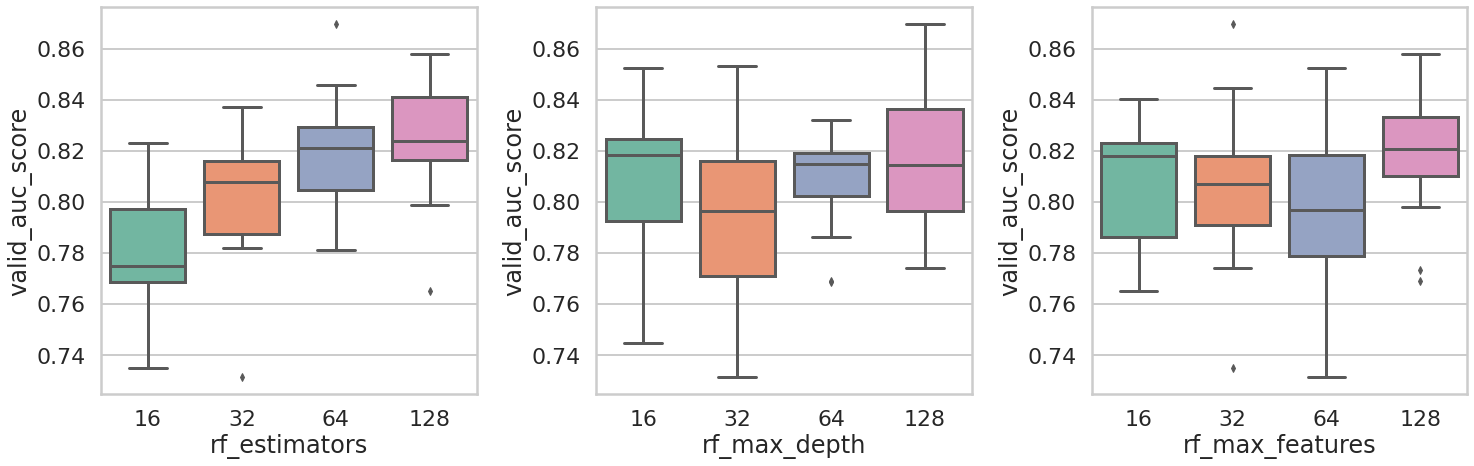

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_auc_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_auc_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_auc_score", ax=ax[2])
fig.tight_layout()

In [ ]:
estimators = [64,100,200,300]
depth=[64,128,200]
features=[32,64,128,200]

rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []
for rf_estimator in estimators:
    for rf_depth in depth:
        for rf_feature in features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_auc = pred_results['roc_auc_score']
            valid_auc_list.append(valid_auc)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-08 20:53:50,596 Previous dataset split restored
2021-04-08 20:53:57,975 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/0609ddd0-cb66-491e-b86d-64df05597365/model_metadata.json
2021-04-08 20:53:58,013 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/0609ddd0-cb66-491e-b86d-64df05597365/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_0609ddd0-cb66-491e-b86d-64df05597365.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.821555068308315
number of features: 1024


2021-04-08 20:55:13,635 Previous dataset split restored
2021-04-08 20:55:22,811 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6e44b1de-c756-4581-b4ab-089d1da8f8a7/model_metadata.json
2021-04-08 20:55:22,843 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6e44b1de-c756-4581-b4ab-089d1da8f8a7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_6e44b1de-c756-4581-b4ab-089d1da8f8a7.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.834609546297858
number of features: 1024


2021-04-08 20:56:38,576 Previous dataset split restored
2021-04-08 20:56:50,981 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/786c857f-a746-49cf-9541-0d66acf01772/model_metadata.json
2021-04-08 20:56:51,007 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/786c857f-a746-49cf-9541-0d66acf01772/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_786c857f-a746-49cf-9541-0d66acf01772.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8059762748074436
number of features: 1024


2021-04-08 20:58:06,541 Previous dataset split restored
2021-04-08 20:58:22,642 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/10f2889b-2df9-4fe3-9789-744cfef49128/model_metadata.json
2021-04-08 20:58:22,667 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/10f2889b-2df9-4fe3-9789-744cfef49128/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_10f2889b-2df9-4fe3-9789-744cfef49128.tar.gz
rf_estimators: 64, rf_max_depth: 64, rf_max_features: 200, valid_auc: 0.7991566874683758
number of features: 1024


2021-04-08 20:59:38,210 Previous dataset split restored
2021-04-08 20:59:45,480 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/5dc9c4e0-e9e1-4ea5-bc61-370dc1b0df17/model_metadata.json
2021-04-08 20:59:45,518 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/5dc9c4e0-e9e1-4ea5-bc61-370dc1b0df17/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_5dc9c4e0-e9e1-4ea5-bc61-370dc1b0df17.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.7732894810816888
number of features: 1024


2021-04-08 21:01:01,094 Previous dataset split restored
2021-04-08 21:01:09,952 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/911232fb-7c95-4018-8c51-8ae11fb3c2bc/model_metadata.json
2021-04-08 21:01:09,982 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/911232fb-7c95-4018-8c51-8ae11fb3c2bc/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_911232fb-7c95-4018-8c51-8ae11fb3c2bc.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.8076516557036038
number of features: 1024


2021-04-08 21:02:25,525 Previous dataset split restored
2021-04-08 21:02:37,485 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e3c4781f-a913-4791-9097-0ed205a9c8b5/model_metadata.json
2021-04-08 21:02:37,513 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e3c4781f-a913-4791-9097-0ed205a9c8b5/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_e3c4781f-a913-4791-9097-0ed205a9c8b5.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.806375442739079
number of features: 1024


2021-04-08 21:03:52,941 Previous dataset split restored
2021-04-08 21:04:08,559 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/44ca529c-f022-455a-9113-24ed6a718037/model_metadata.json
2021-04-08 21:04:08,585 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/44ca529c-f022-455a-9113-24ed6a718037/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_44ca529c-f022-455a-9113-24ed6a718037.tar.gz
rf_estimators: 64, rf_max_depth: 128, rf_max_features: 200, valid_auc: 0.8195592286501377
number of features: 1024


2021-04-08 21:05:24,024 Previous dataset split restored
2021-04-08 21:05:31,305 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/074e188e-899c-4385-a150-f35871defb04/model_metadata.json
2021-04-08 21:05:31,343 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/074e188e-899c-4385-a150-f35871defb04/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_074e188e-899c-4385-a150-f35871defb04.tar.gz
rf_estimators: 64, rf_max_depth: 200, rf_max_features: 32, valid_auc: 0.8521841794569067
number of features: 1024


2021-04-08 21:06:46,850 Previous dataset split restored
2021-04-08 21:06:55,485 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a611de3a-343a-45c5-91fb-1044916ca0cf/model_metadata.json
2021-04-08 21:06:55,516 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a611de3a-343a-45c5-91fb-1044916ca0cf/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_a611de3a-343a-45c5-91fb-1044916ca0cf.tar.gz
rf_estimators: 64, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8257435205487154
number of features: 1024


2021-04-08 21:08:10,933 Previous dataset split restored
2021-04-08 21:08:22,801 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/2778d775-108e-4c77-92f1-22dd64198703/model_metadata.json
2021-04-08 21:08:22,828 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/2778d775-108e-4c77-92f1-22dd64198703/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_2778d775-108e-4c77-92f1-22dd64198703.tar.gz
rf_estimators: 64, rf_max_depth: 200, rf_max_features: 128, valid_auc: 0.8025186934277844
number of features: 1024


2021-04-08 21:09:38,445 Previous dataset split restored
2021-04-08 21:09:54,229 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/5bc97468-9efd-40a3-ba9e-6e5c3e4ca9ae/model_metadata.json
2021-04-08 21:09:54,255 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/5bc97468-9efd-40a3-ba9e-6e5c3e4ca9ae/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_5bc97468-9efd-40a3-ba9e-6e5c3e4ca9ae.tar.gz
rf_estimators: 64, rf_max_depth: 200, rf_max_features: 200, valid_auc: 0.8138471917692697
number of features: 1024


2021-04-08 21:11:09,981 Previous dataset split restored
2021-04-08 21:11:18,329 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/4c391e78-da3f-482c-9446-05a5a935d78f/model_metadata.json
2021-04-08 21:11:18,386 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/4c391e78-da3f-482c-9446-05a5a935d78f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_4c391e78-da3f-482c-9446-05a5a935d78f.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.7583066284364985
number of features: 1024


2021-04-08 21:12:33,758 Previous dataset split restored
2021-04-08 21:12:44,401 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b4dea980-67d9-45bf-9255-f7d5722f9f8d/model_metadata.json
2021-04-08 21:12:44,447 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b4dea980-67d9-45bf-9255-f7d5722f9f8d/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_b4dea980-67d9-45bf-9255-f7d5722f9f8d.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.8236071288019341
number of features: 1024


2021-04-08 21:13:59,842 Previous dataset split restored
2021-04-08 21:14:15,792 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d51cda22-f20a-4c12-8f2a-f7fca1d6472c/model_metadata.json
2021-04-08 21:14:15,832 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d51cda22-f20a-4c12-8f2a-f7fca1d6472c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_d51cda22-f20a-4c12-8f2a-f7fca1d6472c.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.812846460898409
number of features: 1024


2021-04-08 21:15:31,340 Previous dataset split restored
2021-04-08 21:15:53,292 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/55e89e2a-1194-42f7-9cd7-914ae55a58c2/model_metadata.json
2021-04-08 21:15:53,327 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/55e89e2a-1194-42f7-9cd7-914ae55a58c2/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_55e89e2a-1194-42f7-9cd7-914ae55a58c2.tar.gz
rf_estimators: 100, rf_max_depth: 64, rf_max_features: 200, valid_auc: 0.8016247821442627
number of features: 1024


2021-04-08 21:17:09,191 Previous dataset split restored
2021-04-08 21:17:17,450 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/36948fed-f675-4c80-aa58-d344368bd41b/model_metadata.json
2021-04-08 21:17:17,505 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/36948fed-f675-4c80-aa58-d344368bd41b/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_36948fed-f675-4c80-aa58-d344368bd41b.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.7946252881317816
number of features: 1024


2021-04-08 21:18:32,881 Previous dataset split restored
2021-04-08 21:18:43,491 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/86588a8f-7fd6-44b6-8a36-ee7ba02e4cf4/model_metadata.json
2021-04-08 21:18:43,537 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/86588a8f-7fd6-44b6-8a36-ee7ba02e4cf4/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_86588a8f-7fd6-44b6-8a36-ee7ba02e4cf4.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.7951087873165794
number of features: 1024


2021-04-08 21:19:59,324 Previous dataset split restored
2021-04-08 21:20:15,006 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/43f430d3-d5fb-4e77-9e60-0c05344c09e1/model_metadata.json
2021-04-08 21:20:15,046 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/43f430d3-d5fb-4e77-9e60-0c05344c09e1/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_43f430d3-d5fb-4e77-9e60-0c05344c09e1.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.823640861303199
number of features: 1024


2021-04-08 21:21:30,943 Previous dataset split restored
2021-04-08 21:21:52,581 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b4c203f1-5980-4a68-9888-17535bc5a15c/model_metadata.json
2021-04-08 21:21:52,617 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b4c203f1-5980-4a68-9888-17535bc5a15c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_b4c203f1-5980-4a68-9888-17535bc5a15c.tar.gz
rf_estimators: 100, rf_max_depth: 128, rf_max_features: 200, valid_auc: 0.8313262495080678
number of features: 1024


2021-04-08 21:23:08,154 Previous dataset split restored
2021-04-08 21:23:16,589 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/f7bed4a1-bf50-40f4-8e1a-a992f1865da6/model_metadata.json
2021-04-08 21:23:16,645 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/f7bed4a1-bf50-40f4-8e1a-a992f1865da6/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_f7bed4a1-bf50-40f4-8e1a-a992f1865da6.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 32, valid_auc: 0.8108674874908641
number of features: 1024


2021-04-08 21:24:32,099 Previous dataset split restored
2021-04-08 21:24:43,268 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a551db8b-7648-4741-a6eb-5375c73e39cc/model_metadata.json
2021-04-08 21:24:43,314 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a551db8b-7648-4741-a6eb-5375c73e39cc/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_a551db8b-7648-4741-a6eb-5375c73e39cc.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8075898127846179
number of features: 1024


2021-04-08 21:25:59,601 Previous dataset split restored
2021-04-08 21:26:15,349 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b0dfbf15-ad99-4b5e-b201-55e239f5b7d7/model_metadata.json
2021-04-08 21:26:15,390 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b0dfbf15-ad99-4b5e-b201-55e239f5b7d7/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_b0dfbf15-ad99-4b5e-b201-55e239f5b7d7.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 128, valid_auc: 0.8145330859616574
number of features: 1024


2021-04-08 21:27:31,100 Previous dataset split restored
2021-04-08 21:27:52,477 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/604fd2cf-ce7c-4005-a47a-65cbd81b2f5c/model_metadata.json
2021-04-08 21:27:52,515 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/604fd2cf-ce7c-4005-a47a-65cbd81b2f5c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_604fd2cf-ce7c-4005-a47a-65cbd81b2f5c.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 200, valid_auc: 0.8562770562770563
number of features: 1024


2021-04-08 21:29:07,930 Previous dataset split restored
2021-04-08 21:29:19,262 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6224a018-28b7-4dc2-94fc-7e760e9d0406/model_metadata.json
2021-04-08 21:29:19,369 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6224a018-28b7-4dc2-94fc-7e760e9d0406/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_6224a018-28b7-4dc2-94fc-7e760e9d0406.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.8329903862371395
number of features: 1024


2021-04-08 21:30:34,796 Previous dataset split restored
2021-04-08 21:30:50,968 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e13e9b2b-89c7-46a4-b09e-38f34f2aa74f/model_metadata.json
2021-04-08 21:30:51,056 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e13e9b2b-89c7-46a4-b09e-38f34f2aa74f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_e13e9b2b-89c7-46a4-b09e-38f34f2aa74f.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.7823016810029797
number of features: 1024


2021-04-08 21:32:07,033 Previous dataset split restored
2021-04-08 21:32:33,136 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a1b26c61-ef83-445b-8bf5-1922fb022d86/model_metadata.json
2021-04-08 21:32:33,209 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/a1b26c61-ef83-445b-8bf5-1922fb022d86/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_a1b26c61-ef83-445b-8bf5-1922fb022d86.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8193287232248272
number of features: 1024


2021-04-08 21:33:48,732 Previous dataset split restored
2021-04-08 21:34:27,018 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/3c2eb9eb-49f3-4014-9320-a8febd7e69e2/model_metadata.json
2021-04-08 21:34:27,085 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/3c2eb9eb-49f3-4014-9320-a8febd7e69e2/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_3c2eb9eb-49f3-4014-9320-a8febd7e69e2.tar.gz
rf_estimators: 200, rf_max_depth: 64, rf_max_features: 200, valid_auc: 0.8466970259178052
number of features: 1024


2021-04-08 21:35:42,815 Previous dataset split restored
2021-04-08 21:35:54,149 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/59169a5a-3159-4741-bb6d-d306a3d327f6/model_metadata.json
2021-04-08 21:35:54,255 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/59169a5a-3159-4741-bb6d-d306a3d327f6/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_59169a5a-3159-4741-bb6d-d306a3d327f6.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.8477314892899308
number of features: 1024


2021-04-08 21:37:10,094 Previous dataset split restored
2021-04-08 21:37:26,275 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6d09c85f-c528-4dfe-a931-4be095e1836e/model_metadata.json
2021-04-08 21:37:26,363 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6d09c85f-c528-4dfe-a931-4be095e1836e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_6d09c85f-c528-4dfe-a931-4be095e1836e.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.8256929217968181
number of features: 1024


2021-04-08 21:38:42,404 Previous dataset split restored
2021-04-08 21:39:08,837 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d6228dbb-d352-45eb-a4ff-557fc387c531/model_metadata.json
2021-04-08 21:39:08,913 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d6228dbb-d352-45eb-a4ff-557fc387c531/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_d6228dbb-d352-45eb-a4ff-557fc387c531.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.8248833417664587
number of features: 1024


2021-04-08 21:40:24,507 Previous dataset split restored
2021-04-08 21:41:03,049 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/68805ba0-19a1-436f-8bc3-6dbb288a042e/model_metadata.json
2021-04-08 21:41:03,116 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/68805ba0-19a1-436f-8bc3-6dbb288a042e/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_68805ba0-19a1-436f-8bc3-6dbb288a042e.tar.gz
rf_estimators: 200, rf_max_depth: 128, rf_max_features: 200, valid_auc: 0.8125035138022152
number of features: 1024


2021-04-08 21:42:18,944 Previous dataset split restored
2021-04-08 21:42:30,406 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b7e46061-e174-46c0-a313-c1aeef5b9770/model_metadata.json
2021-04-08 21:42:30,513 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/b7e46061-e174-46c0-a313-c1aeef5b9770/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_b7e46061-e174-46c0-a313-c1aeef5b9770.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 32, valid_auc: 0.8355540563332773
number of features: 1024


2021-04-08 21:43:46,185 Previous dataset split restored
2021-04-08 21:44:02,435 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/98797fc8-e857-4a06-b326-33647a76c671/model_metadata.json
2021-04-08 21:44:02,523 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/98797fc8-e857-4a06-b326-33647a76c671/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_98797fc8-e857-4a06-b326-33647a76c671.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8418901444875472
number of features: 1024


2021-04-08 21:45:18,255 Previous dataset split restored
2021-04-08 21:45:44,869 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e317a313-b6d2-47d8-a7d8-281156f7432c/model_metadata.json
2021-04-08 21:45:44,944 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/e317a313-b6d2-47d8-a7d8-281156f7432c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_e317a313-b6d2-47d8-a7d8-281156f7432c.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 128, valid_auc: 0.8466801596671726
number of features: 1024


2021-04-08 21:47:00,641 Previous dataset split restored
2021-04-08 21:47:40,470 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/9e5e0741-6cd9-4687-91dc-d7c449f06ab3/model_metadata.json
2021-04-08 21:47:40,539 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/9e5e0741-6cd9-4687-91dc-d7c449f06ab3/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_9e5e0741-6cd9-4687-91dc-d7c449f06ab3.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 200, valid_auc: 0.817861359419801
number of features: 1024


2021-04-08 21:48:56,421 Previous dataset split restored
2021-04-08 21:49:10,941 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/32901ce3-80d5-4b76-a8c5-bb7014d991d1/model_metadata.json
2021-04-08 21:49:11,100 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/32901ce3-80d5-4b76-a8c5-bb7014d991d1/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_32901ce3-80d5-4b76-a8c5-bb7014d991d1.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 32, valid_auc: 0.8437510541406645
number of features: 1024


2021-04-08 21:50:26,699 Previous dataset split restored
2021-04-08 21:50:48,607 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/74d1cda9-7770-431a-92dd-47e1d4df62d6/model_metadata.json
2021-04-08 21:50:48,733 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/74d1cda9-7770-431a-92dd-47e1d4df62d6/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_74d1cda9-7770-431a-92dd-47e1d4df62d6.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 64, valid_auc: 0.830780907404284
number of features: 1024


2021-04-08 21:52:04,623 Previous dataset split restored
2021-04-08 21:52:42,224 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/366e36ba-f5de-4bd8-87bb-58e094477dc1/model_metadata.json
2021-04-08 21:52:42,332 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/366e36ba-f5de-4bd8-87bb-58e094477dc1/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_366e36ba-f5de-4bd8-87bb-58e094477dc1.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 128, valid_auc: 0.8521785573733627
number of features: 1024


2021-04-08 21:53:58,330 Previous dataset split restored
2021-04-08 21:54:52,921 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d2bd2993-658b-4df7-b5ec-24ee50fc5def/model_metadata.json
2021-04-08 21:54:53,025 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d2bd2993-658b-4df7-b5ec-24ee50fc5def/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_d2bd2993-658b-4df7-b5ec-24ee50fc5def.tar.gz
rf_estimators: 300, rf_max_depth: 64, rf_max_features: 200, valid_auc: 0.8493843818519143
number of features: 1024


2021-04-08 21:56:08,844 Previous dataset split restored
2021-04-08 21:56:23,421 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/02bfe659-903b-436c-ad8b-1c3f5aa3c283/model_metadata.json
2021-04-08 21:56:23,580 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/02bfe659-903b-436c-ad8b-1c3f5aa3c283/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_02bfe659-903b-436c-ad8b-1c3f5aa3c283.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 32, valid_auc: 0.8227694383538541
number of features: 1024


2021-04-08 21:57:39,538 Previous dataset split restored
2021-04-08 21:58:01,239 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/9a06d5ba-6ba1-4906-9137-68489f3eff09/model_metadata.json
2021-04-08 21:58:01,370 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/9a06d5ba-6ba1-4906-9137-68489f3eff09/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_9a06d5ba-6ba1-4906-9137-68489f3eff09.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 64, valid_auc: 0.8306628436498568
number of features: 1024


2021-04-08 21:59:17,418 Previous dataset split restored
2021-04-08 21:59:53,878 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/8f17f180-19a5-47cf-a83e-d154e8dcf4e4/model_metadata.json
2021-04-08 21:59:53,986 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/8f17f180-19a5-47cf-a83e-d154e8dcf4e4/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_8f17f180-19a5-47cf-a83e-d154e8dcf4e4.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 128, valid_auc: 0.833873053353573
number of features: 1024


2021-04-08 22:01:09,952 Previous dataset split restored
2021-04-08 22:02:03,721 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d3f0f9e7-3e68-4bcc-8d1e-a206320e6d94/model_metadata.json
2021-04-08 22:02:03,819 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/d3f0f9e7-3e68-4bcc-8d1e-a206320e6d94/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_d3f0f9e7-3e68-4bcc-8d1e-a206320e6d94.tar.gz
rf_estimators: 300, rf_max_depth: 128, rf_max_features: 200, valid_auc: 0.8421881149153876
number of features: 1024


2021-04-08 22:03:19,635 Previous dataset split restored
2021-04-08 22:03:34,107 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/39d8d36e-85fc-48f8-b4a9-1206521e6f1f/model_metadata.json
2021-04-08 22:03:34,262 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/39d8d36e-85fc-48f8-b4a9-1206521e6f1f/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_39d8d36e-85fc-48f8-b4a9-1206521e6f1f.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 32, valid_auc: 0.8239781863158486
number of features: 1024


2021-04-08 22:04:50,052 Previous dataset split restored
2021-04-08 22:05:11,706 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/fbbf93fb-7314-4da5-aad6-cf2259bd1885/model_metadata.json
2021-04-08 22:05:11,839 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/fbbf93fb-7314-4da5-aad6-cf2259bd1885/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_fbbf93fb-7314-4da5-aad6-cf2259bd1885.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8761904761904762
number of features: 1024


2021-04-08 22:06:27,715 Previous dataset split restored
2021-04-08 22:07:05,376 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6d0ce28a-e104-4a25-9d07-70b66907626c/model_metadata.json
2021-04-08 22:07:05,488 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/6d0ce28a-e104-4a25-9d07-70b66907626c/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_6d0ce28a-e104-4a25-9d07-70b66907626c.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 128, valid_auc: 0.8581154775959972
number of features: 1024


2021-04-08 22:08:21,392 Previous dataset split restored
2021-04-08 22:09:16,261 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/0ff05b40-d365-47ba-9b63-7b1b7560876a/model_metadata.json
2021-04-08 22:09:16,363 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/0ff05b40-d365-47ba-9b63-7b1b7560876a/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_0ff05b40-d365-47ba-9b63-7b1b7560876a.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 200, valid_auc: 0.8453083712823972


In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_score": valid_auc_list})
perf_df.sort_values(by="valid_auc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_auc_score
45,300,200,64,0.876190
46,300,200,128,0.858115
23,100,200,200,0.856277
8,64,200,32,0.852184
38,300,64,128,0.852179
39,300,64,200,0.849384
28,200,128,32,0.847731
27,200,64,200,0.846697
34,200,200,128,0.846680
47,300,200,200,0.845308


In [ ]:
working_dir = '/content'
import atomsci.ddm.pipeline.compare_models as cmp
model_class =cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)
model_class.to_csv('best_class_model.csv')

Found data for 49 models under ampl_output
Copied CYP3A4_cur_final_model_fbbf93fb-7314-4da5-aad6-cf2259bd1885.tar.gz


In [16]:
estimators = [300]
depth=[200]
features=[64]

rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []
for rf_estimator in estimators:
    for rf_depth in depth:
        for rf_feature in features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_auc = pred_results['roc_auc_score']
            valid_auc_list.append(valid_auc)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-28 00:19:16,586 Previous dataset split restored
2021-04-28 00:19:40,265 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/64211792-4a4e-4789-be19-0913489972fc/model_metadata.json
2021-04-28 00:19:40,393 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/64211792-4a4e-4789-be19-0913489972fc/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_64211792-4a4e-4789-be19-0913489972fc.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8500815202113902


In [20]:
estimators = [300]
depth=[200]
features=[64]

rfe_list = []
rfd_list = []
rff_list = []
valid_auc_list = []
for rf_estimator in estimators:
    for rf_depth in depth:
        for rf_feature in features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_auc = pred_results['roc_auc_score']
            valid_auc_list.append(valid_auc)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_auc: {valid_auc}")

number of features: 1024


2021-04-28 00:24:03,002 Previous dataset split restored
2021-04-28 00:24:24,959 Wrote model metadata to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/01f49749-5d80-4145-9cc8-92b8b914b319/model_metadata.json
2021-04-28 00:24:25,088 Wrote model metrics to file ampl_output/CYP3A4_cur_final/RF_ecfp_scaffold_classification/01f49749-5d80-4145-9cc8-92b8b914b319/model_metrics.json


Wrote model tarball to ampl_output/CYP3A4_cur_final_model_01f49749-5d80-4145-9cc8-92b8b914b319.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 64, valid_auc: 0.8536290549277561


In [21]:
from atomsci.ddm.pipeline import predict_from_model

In [22]:
!wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/curated_combined_df.csv

--2021-04-28 00:26:49--  https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/curated_combined_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633765 (619K) [text/plain]
Saving to: ‘curated_combined_df.csv’

curated_combined_df 100%[===================>] 618.91K  --.-KB/s    in 0.03s   

2021-04-28 00:26:50 (20.7 MB/s) - ‘curated_combined_df.csv’ saved [633765/633765]



In [25]:
fan=pd.read_csv('curated_combined_df.csv',index_col=0)

In [33]:
fan['rdkit_smiles']=fan['base_rdkit_smiles']

In [36]:
fan_no_overlap=fan[~fan.rdkit_smiles.isin(h1.rdkit_smiles)]

In [30]:
test = predict_from_model.predict_from_model_file(model_path='ampl_output/CYP3A4_cur_final_model_01f49749-5d80-4145-9cc8-92b8b914b319.tar.gz',
                            input_df = fan_no_overlap,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='active',
                            is_featurized=False,
                            dont_standardize=True)

2021-04-28 00:33:51,514 ['ampl_version', 'time_generated', 'time_built', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


Featurization = DynamicFeaturization with ecfp features
number of features: 1024


In [37]:
results_df = pl.predict_on_dataframe(fan_no_overlap, contains_responses=True)
results_df

number of features: 1024


,rdkit_smiles,actual,pred
compound_id,,,
CKLPLPZSUQEDRT-WPCRTTGESA-N,C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...,0.0,0
REFJWTPEDVJJIY-UHFFFAOYSA-N,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,0.0,0
DWTYHCYVKJONSP-UHFFFAOYSA-N,O=C(O)c1cc(-c2cccc(COc3ccc4c(c3)CN(C3CCCC3)C4=...,0.0,0
CHEMBL596133,CS(=O)(=O)NC1CC12CCN(S(=O)(=O)c1cc(Cl)ccc1S(=O...,0.0,0
CHEMBL4078588,Cc1ccc(Cc2cc3c(=O)n([C@H]4CCCC[C@@H]4O)cnc3c3c...,0.0,0
...,...,...,...
CHEMBL1581082,COc1cc(C(=O)NC(=S)Nc2ccc(Cl)c(C(=O)O)c2)cc(OC)...,0.0,0
CHEMBL1447410,CCOc1c2ccc(C(=O)NCc3ccc(OC(F)(F)F)cc3)cc2nn1CC,0.0,0
CHEMBL1450781,COc1ccc(C(=O)COC(=O)c2ccc(NC(=O)c3ccccc3)cc2)cc1,1.0,0


In [39]:
from sklearn.metrics import roc_auc_score
y_true = results_df['actual'].values
y_pred = results_df['pred'].values
roc_auc_score(y_true, y_pred)

0.499426898687737

In [41]:
!wget https://raw.githubusercontent.com/js5783/E4511-2021-Shen/main/Dataset/delaney_curated_final.csv

--2021-04-28 00:51:10--  https://raw.githubusercontent.com/js5783/E4511-2021-Shen/main/Dataset/delaney_curated_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2231626 (2.1M) [text/plain]
Saving to: ‘delaney_curated_final.csv’

delaney_curated_fin 100%[===================>]   2.13M  --.-KB/s    in 0.07s   

2021-04-28 00:51:10 (30.7 MB/s) - ‘delaney_curated_final.csv’ saved [2231626/2231626]



In [52]:
shen=pd.read_csv('delaney_curated_final.csv')

In [53]:
shen

,compound_id,base_rdkit_smiles,relation,pXC50,active,rdkit_smiles,inchi_key,Compound_Id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,CHEMBL245412,C/C1=C\CC(C)(C)/C=C/C(=O)/C(C)=C/CC1,NaN,2.027809,0,C/C1=C\CC(C)(C)/C=C/C(=O)/C(C)=C/CC1,GIHNTRQPEMKFKO-SKTNYSRSSA-N,GIHNTRQPEMKFKO-SKTNYSRSSA-N,2.027809,NaN,0.0,0
1,CHEMBL1419469,Cc1ccccc1NC(=O)Cc1c(O)nc2ccccc2c1O,NaN,2.050000,0,Cc1ccccc1NC(=O)Cc1c(O)nc2ccccc2c1O,HYBPGKKEHPSNRR-UHFFFAOYSA-N,HYBPGKKEHPSNRR-UHFFFAOYSA-N,2.050000,NaN,0.0,0
2,CHEMBL1093607,CC(c1c(CCN(C)C)sc2ccccc12)n1ccnc1,NaN,2.097506,0,CC(c1c(CCN(C)C)sc2ccccc12)n1ccnc1,MSPFRPWEGPBFTC-UHFFFAOYSA-N,MSPFRPWEGPBFTC-UHFFFAOYSA-N,2.097506,NaN,0.0,0
3,CHEMBL66654,Cc1cccc(C#Cc2ccccc2)n1,NaN,2.233919,0,Cc1cccc(C#Cc2ccccc2)n1,NEWKHUASLBMWRE-UHFFFAOYSA-N,NEWKHUASLBMWRE-UHFFFAOYSA-N,2.233919,NaN,0.0,0
4,CHEMBL1091782,C[C@@H](c1cscn1)c1c(CCN(C)C)sc2ccccc12,NaN,2.308753,0,C[C@@H](c1cscn1)c1c(CCN(C)C)sc2ccccc12,GUNAZEDORZMWRN-LBPRGKRZSA-N,GUNAZEDORZMWRN-LBPRGKRZSA-N,2.308753,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11287,CHEMBL1089116,CCn1cc(-c2ccnc3[nH]ccc23)c(-c2ccc(NC(=O)Nc3ccc...,NaN,10.068432,1,CCn1cc(-c2ccnc3[nH]ccc23)c(-c2ccc(NC(=O)Nc3ccc...,CZVVMRNEBRFYTL-UHFFFAOYSA-N,CZVVMRNEBRFYTL-UHFFFAOYSA-N,10.068432,NaN,0.0,0
11288,CHEMBL1081870,Cc1cccc(C)c1CNc1nccc2c1nc(C)n2C,NaN,10.068432,1,Cc1cccc(C)c1CNc1nccc2c1nc(C)n2C,RFFMAFBDIYXZRC-UHFFFAOYSA-N,RFFMAFBDIYXZRC-UHFFFAOYSA-N,10.068432,NaN,0.0,0
11289,53392850,CN1C[C@H]2CCCC[C@@]2(Cc2ccc(Cl)c(Cl)c2)C1,NaN,10.369462,1,CN1C[C@H]2CCCC[C@@]2(Cc2ccc(Cl)c(Cl)c2)C1,CHWUQEOFMAPDHN-CZUORRHYSA-N,CHWUQEOFMAPDHN-CZUORRHYSA-N,10.369462,NaN,0.0,0
11290,53392852,Clc1ccc(C[C@@]23CCCC[C@@H]2CNC3)cc1Cl,NaN,10.369462,1,Clc1ccc(C[C@@]23CCCC[C@@H]2CNC3)cc1Cl,MEAWOAPXKTVYPU-IUODEOHRSA-N,MEAWOAPXKTVYPU-IUODEOHRSA-N,10.369462,NaN,0.0,0


In [58]:
shen_no_overlap=shen[~shen.rdkit_smiles.isin(h1.rdkit_smiles)]

In [59]:
results_df = pl.predict_on_dataframe(shen_no_overlap, contains_responses=True)
results_df

number of features: 1024


,rdkit_smiles,actual,pred
compound_id,,,
CHEMBL1419469,Cc1ccccc1NC(=O)Cc1c(O)nc2ccccc2c1O,0.0,0
CHEMBL4442292,O=C(O)CCCCCNn1nnc2ccccc21,0.0,0
CHEMBL363082,O=CC(O)C(O)C(O)C(CO)NC(=O)N(CCCl)N=O,0.0,0
CHEMBL498372,CC(C)(C)c1cc(/C=C2\CC/C(=C\c3cc(C(C)(C)C)c(O)c...,0.0,0
CHEMBL1933690,COCO[C@@H](c1ccccc1)[C@@H](Cn1ccnn1)c1ccccc1,0.0,0
...,...,...,...
CHEMBL1078344,O=S(=O)(Cc1ccc2c(c1)CCNCC2)c1ccc(-c2ccc(Cl)cc2...,1.0,0
CHEMBL1078267,O=S(=O)(Cc1ccc2c(c1)CCNCC2)c1ccc(-c2ccc(Cl)cc2...,1.0,0
CHEMBL1089116,CCn1cc(-c2ccnc3[nH]ccc23)c(-c2ccc(NC(=O)Nc3ccc...,1.0,0


In [60]:
from sklearn.metrics import roc_auc_score
y_true = results_df['actual'].values
y_pred = results_df['pred'].values
roc_auc_score(y_true, y_pred)

0.4994335882186349

In [61]:
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/data_for_model_MAOA.csv

--2021-04-28 00:59:18--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/data_for_model_MAOA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355064 (347K) [text/plain]
Saving to: ‘data_for_model_MAOA.csv’

data_for_model_MAOA 100%[===================>] 346.74K  --.-KB/s    in 0.03s   

2021-04-28 00:59:18 (10.3 MB/s) - ‘data_for_model_MAOA.csv’ saved [355064/355064]



In [74]:
fu=pd.read_csv('data_for_model_MAOA.csv')

In [75]:
fu=fu.iloc[:,2:]

In [77]:
fu['rdkit_smiles']=fu['base_rdkit_smiles']

In [78]:
fu_no_overlap=fu[~fu.rdkit_smiles.isin(h1.rdkit_smiles)]

In [79]:
results_df = pl.predict_on_dataframe(fu_no_overlap, contains_responses=True)
results_df

number of features: 1024


,rdkit_smiles,actual,pred
compound_id,,,
CHEMBL248049,CC1CCC(=NNc2nc(-c3ccc(Cl)cc3)cs2)CC1,0.0,0
CHEMBL3942207,N#Cc1ccccc1S(=O)(=O)Nc1cccc(-c2ncc([C@H]3C[C@@...,0.0,0
CHEMBL3651121,Clc1ncccc1CN[C@H]1CC1c1ccccc1,0.0,0
CHEMBL4206777,NC(=O)c1ccc(OCc2cccc(C(F)(F)F)c2)cc1,0.0,0
CHEMBL3771110,CC(=O)c1cccc(OCc2ccc(Cl)cc2)c1,0.0,0
...,...,...,...
CHEMBL1830793,CC(=O)c1cc2cc(O)ccc2oc1=O,0.0,0
CHEMBL3218145,c1ccc2cc(-c3csc(NN=C4CCCCC4)n3)ccc2c1,0.0,0
CHEMBL3330342,N[C@@]1(Cc2ccccc2)C[C@@H]1c1ccccc1,0.0,0


In [80]:
from sklearn.metrics import roc_auc_score
y_true = results_df['actual'].values
y_pred = results_df['pred'].values
roc_auc_score(y_true, y_pred)

0.5